In [1]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import pickle

In [2]:
def read_excel(path):
    return pd.read_excel(path)

In [3]:
path_1 = '../Data/Preprocessing/Data Balonggandu/2023/2_input_balonggandu_2023.xlsx'
# path_2 = '../Data/Preprocessing/Data Losarang/2022/2_input_losarang_2022.xlsx'
# path_3 = '../Data/Preprocessing/Data Losarang/2023/2_input_losarang_2023.xlsx'

balonggandu_2023 = read_excel(path_1)
# losarang_2022 = read_excel(path_2)
# losarang_2023 = read_excel(path_3)

df = pd.concat([balonggandu_2023], ignore_index=True)

In [4]:
df.head()

,WAKTU,TAHUN,BULAN,PEKAN,TANGGAL,HARI,JAM,MOTOR,MOBIL,TRUK/BUS,JUMLAH,SMP_MTR,SMP_MBL,SMP_TRK,SMP
0,2023-01-01 00:00:00,2023,1,1,1,Sunday,00:00,103,25,14,142,82.4,25,35.0,142
1,2023-01-01 00:15:00,2023,1,1,1,Sunday,00:15,111,16,12,139,88.8,16,30.0,135
2,2023-01-01 00:30:00,2023,1,1,1,Sunday,00:30,114,26,6,146,91.2,26,15.0,132
3,2023-01-01 00:45:00,2023,1,1,1,Sunday,00:45,76,24,11,111,60.8,24,27.5,112
4,2023-01-01 01:00:00,2023,1,1,1,Sunday,01:00,73,24,7,104,58.4,24,17.5,100


In [5]:
# Menghitung IQR dan menghilangkan outlier untuk setiap kombinasi hari dan jam
def remove_outliers(df, column):
    # Mengelompokkan data berdasarkan 'HARI' dan 'JAM'
    grouped = df.groupby(['HARI', 'JAM'])

    # Fungsi untuk menghitung batas dan memfilter outlier
    def filter_outliers(sub_df):
        Q1 = sub_df[column].quantile(0.25)
        Q3 = sub_df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return sub_df[(sub_df[column] >= lower_bound) & (sub_df[column] <= upper_bound)]
    
    # Menerapkan filter outlier ke setiap grup
    return grouped.apply(filter_outliers).reset_index(drop=True)

# Asumsikan y_test adalah nilai aktual dan predictions adalah nilai yang diprediksi oleh model
def calculate_mape(y_true, y_pred):
    # Menghindari pembagian dengan nol
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

In [6]:
a = len(df)
# Kolom untuk dibersihkan dari outlier, misal 'MOTOR'
df = remove_outliers(df, 'SMP')
b = len(df)

In [7]:
print(a, b, a-b)

35040 29694 5346


In [8]:
data = df.copy()

In [9]:
# Preprocessing
encoder = OneHotEncoder(sparse_output=False)
scaled_features = StandardScaler()

In [10]:
# Misal meng-encode fitur 'HARI'
encoded_days = encoder.fit_transform(df[['HARI']])

In [11]:
# Konversi 'JAM' ke total menit sejak tengah malam
data['JAM'] = df['JAM'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))

In [12]:
# Skala fitur 'JAM', 'MOBIL', 'TRUK/BUS'
scaled_features = scaled_features.fit_transform(data[['JAM', 'MOBIL', 'TRUK/BUS']])

In [13]:
data.head()

,WAKTU,TAHUN,BULAN,PEKAN,TANGGAL,HARI,JAM,MOTOR,MOBIL,TRUK/BUS,JUMLAH,SMP_MTR,SMP_MBL,SMP_TRK,SMP
0,2023-01-06,2023,1,1,6,Friday,0,73,35,40,148,58.4,35,100.0,193
1,2023-01-13,2023,1,2,13,Friday,0,69,47,34,150,55.2,47,85.0,187
2,2023-01-20,2023,1,3,20,Friday,0,50,38,40,128,40.0,38,100.0,178
3,2023-01-27,2023,1,4,27,Friday,0,46,40,49,135,36.8,40,122.5,199
4,2023-02-03,2023,2,1,3,Friday,0,40,39,38,117,32.0,39,95.0,166


In [14]:
# Gabungkan kembali ke DataFrame
encoded_days = pd.DataFrame(encoded_days, columns=encoder.get_feature_names_out(['HARI']))
scaled_features = pd.DataFrame(scaled_features, columns=['JAM', 'MOBIL', 'TRUK/BUS'])
data_preprocessed = pd.concat([data.drop(['HARI', 'JAM', 'MOBIL', 'TRUK/BUS'], axis=1), encoded_days, scaled_features], axis=1)

In [15]:
data_preprocessed.head()

,WAKTU,TAHUN,BULAN,PEKAN,TANGGAL,MOTOR,JUMLAH,SMP_MTR,SMP_MBL,SMP_TRK,...,HARI_Friday,HARI_Monday,HARI_Saturday,HARI_Sunday,HARI_Thursday,HARI_Tuesday,HARI_Wednesday,JAM,MOBIL,TRUK/BUS
0,2023-01-06,2023,1,1,6,73,148,58.4,35,100.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.709464,-1.074966,-0.396155
1,2023-01-13,2023,1,2,13,69,150,55.2,47,85.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.709464,-0.729907,-0.631372
2,2023-01-20,2023,1,3,20,50,128,40.0,38,100.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.709464,-0.988702,-0.396155
3,2023-01-27,2023,1,4,27,46,135,36.8,40,122.5,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.709464,-0.931192,-0.043329
4,2023-02-03,2023,2,1,3,40,117,32.0,39,95.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.709464,-0.959947,-0.474560


# Prediksi Motor

In [16]:
# Bagi data menjadi fitur dan target
X = data_preprocessed.drop(['TAHUN','PEKAN', 'WAKTU','TANGGAL','MOTOR','MOBIL','TRUK/BUS','JUMLAH','SMP_MTR','SMP_MBL','SMP_TRK', 'SMP'], axis=1)
y = data_preprocessed['MOTOR']

In [17]:
# Bagi data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_train

,BULAN,HARI_Friday,HARI_Monday,HARI_Saturday,HARI_Sunday,HARI_Thursday,HARI_Tuesday,HARI_Wednesday,JAM
124,12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.637227
451,10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.384394
16007,7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.999458
1606,10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.481420
6760,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.313198
...,...,...,...,...,...,...,...,...,...
21575,3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.456632
5390,11,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.842609
860,7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.059323
15795,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.854982


In [19]:
y_train

124       46
451       15
16007    350
1606     217
6760     350
        ... 
21575     35
5390     572
860       58
15795    846
23654    287
Name: MOTOR, Length: 23755, dtype: int64

In [20]:
mses = {}
maes = {}
rmses = {}
mapes ={}
r2s  = {}

# Rata-rata hari dan jam

In [21]:
data_terisi_train = df.loc[X_train.index]
data_terisi_test = df.loc[X_test.index]
len(data_terisi_train), len(data_terisi_test), len(data_terisi_test) + len(data_terisi_train)

(23755, 5939, 29694)

In [22]:
data_terisi_test.head()

,WAKTU,TAHUN,BULAN,PEKAN,TANGGAL,HARI,JAM,MOTOR,MOBIL,TRUK/BUS,JUMLAH,SMP_MTR,SMP_MBL,SMP_TRK,SMP
10090,2023-03-25 09:15:00,2023,3,4,25,Saturday,09:15,175,70,72,317,140.0,70,180.0,390
25435,2023-11-01 00:00:00,2023,11,1,1,Wednesday,00:00,37,52,38,127,29.6,52,95.0,177
10094,2023-04-22 09:15:00,2023,4,4,22,Saturday,09:15,242,111,50,403,193.6,111,125.0,430
20228,2023-11-02 18:00:00,2023,11,1,2,Thursday,18:00,330,65,51,446,264.0,65,127.5,456
26378,2023-06-07 05:15:00,2023,6,1,7,Wednesday,05:15,173,21,28,222,138.4,21,70.0,229


In [23]:
def precompute_means(df):
    # Calculate the mean values for each combination of 'BULAN', 'HARI', and 'JAM'
    grouped = df.groupby(['HARI','JAM'])[['MOTOR', 'MOBIL', 'TRUK/BUS']].mean().reset_index()
    return grouped

def find_imputation(precomputed_means, HARI, JAM):
    # Filter the precomputed means DataFrame for the given day and hour
    result = precomputed_means[(precomputed_means['HARI'] == HARI) & (precomputed_means['JAM'] == JAM)]
    return result if not result.empty else pd.DataFrame()

# Assuming data_terisi is the DataFrame from which you want to impute data
precomputed_means = precompute_means(data_terisi_train)

In [24]:
# Iterate over each row in df_missing and fill in values from precomputed means
df_missing = data_terisi_test.copy()
df_missing['MOTOR_ORI'] = df_missing['MOTOR'] 
df_missing['MOBIL_ORI'] = df_missing['MOBIL'] 
df_missing['TRUK/BUS_ORI'] = df_missing['TRUK/BUS'] 
df_missing['MOTOR'] = np.nan
for i, row in df_missing.iterrows():
    if pd.isna(row['MOTOR']):  # Check if MOTOR is NaN
        imputation = find_imputation(precomputed_means, row['HARI'], row['JAM'])
        if not imputation.empty:
            df_missing.at[i, 'MOTOR'] = imputation['MOTOR'].iloc[0]
            df_missing.at[i, 'MOBIL'] = imputation['MOBIL'].iloc[0]
            df_missing.at[i, 'TRUK/BUS'] = imputation['TRUK/BUS'].iloc[0]

In [25]:
df_missing.head()

,WAKTU,TAHUN,BULAN,PEKAN,TANGGAL,HARI,JAM,MOTOR,MOBIL,TRUK/BUS,JUMLAH,SMP_MTR,SMP_MBL,SMP_TRK,SMP,MOTOR_ORI,MOBIL_ORI,TRUK/BUS_ORI
10090,2023-03-25 09:15:00,2023,3,4,25,Saturday,09:15,238.200000,112.200000,51.685714,317,140.0,70,180.0,390,175,70,72
25435,2023-11-01 00:00:00,2023,11,1,1,Wednesday,00:00,50.875000,40.125000,39.062500,127,29.6,52,95.0,177,37,52,38
10094,2023-04-22 09:15:00,2023,4,4,22,Saturday,09:15,238.200000,112.200000,51.685714,403,193.6,111,125.0,430,242,111,50
20228,2023-11-02 18:00:00,2023,11,1,2,Thursday,18:00,324.888889,80.888889,73.444444,446,264.0,65,127.5,456,330,65,51
26378,2023-06-07 05:15:00,2023,6,1,7,Wednesday,05:15,187.805556,40.305556,30.250000,222,138.4,21,70.0,229,173,21,28


In [26]:
y_pred = df_missing['MOTOR']
y_ori = df_missing['MOTOR_ORI']

In [27]:
y_ori

10090    175
25435     37
10094    242
20228    330
26378    173
        ... 
6029     290
29421    149
1866     244
10876    297
19845    274
Name: MOTOR_ORI, Length: 5939, dtype: int64

In [28]:
y_pred = df_missing['MOTOR']
y_ori = df_missing['MOTOR_ORI']

# Menghitung MAE
mae = mean_absolute_error(y_ori, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Menghitung MSE
mse = mean_squared_error(y_ori, y_pred)
print("Mean Squared Error (MSE):", mse)

# Menghitung RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Menghitung R-squared
r2 = r2_score(y_ori, y_pred)
print("R-squared:", r2)

mape = calculate_mape(y_ori, y_pred)
print(f"MAPE: {mape}%")

mses["avg"] = mse
maes["avg"] = mae
rmses["avg"] = rmse
r2s["avg"] = r2
mapes["avg"] = mape

Mean Absolute Error (MAE): 26.0985105903317
Mean Squared Error (MSE): 2225.8865606964887
Root Mean Squared Error (RMSE): 47.17930224893633
R-squared: 0.9030057901148082
MAPE: 16.99849642018931%


In [29]:
df_missing[['MOTOR_ORI','MOTOR','MOBIL_ORI','MOBIL','TRUK/BUS_ORI','TRUK/BUS']].head()

,MOTOR_ORI,MOTOR,MOBIL_ORI,MOBIL,TRUK/BUS_ORI,TRUK/BUS
10090,175,238.200000,70,112.200000,72,51.685714
25435,37,50.875000,52,40.125000,38,39.062500
10094,242,238.200000,111,112.200000,50,51.685714
20228,330,324.888889,65,80.888889,51,73.444444
26378,173,187.805556,21,40.305556,28,30.250000


In [30]:
data_avg = df_missing.rename(columns={'MOTOR': 'Predicted_avg', 'MOTOR_ORI': 'Actual'})
data_avg = data_avg[['Actual','Predicted_avg']].reset_index(drop=True)
data_avg['Residual_avg'] = data_avg['Actual'] - data_avg['Predicted_avg']
data_avg.head()

,Actual,Predicted_avg,Residual_avg
0,175,238.200000,-63.200000
1,37,50.875000,-13.875000
2,242,238.200000,3.800000
3,330,324.888889,5.111111
4,173,187.805556,-14.805556


## Random Forest Regressor

In [31]:
from sklearn.ensemble import RandomForestRegressor

In [32]:
# Latih model RandomForestRegressor
model_rf_mtr = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf_mtr.fit(X_train, y_train)

# Menyimpan model ke dalam file
with open('models/model_rf_mtr_bolanggandu_2022.pkl', 'wb') as file:
    pickle.dump(model_rf_mtr, file)

# Memuat model dari file
with open('models/model_rf_mtr_bolanggandu_2022.pkl', 'rb') as file:
    model_rf_mtr = pickle.load(file)

In [33]:
# Membuat prediksi pada data pengujian
y_pred = model_rf_mtr.predict(X_test)

# Menghitung MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Menghitung MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Menghitung RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Menghitung R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

mape = calculate_mape(y_ori, y_pred)
print(f"MAPE: {mape}%")

mses["rfr"] = mse
maes["rfr"] = mae
rmses["rfr"] = rmse
r2s["rfr"] = r2
mapes["avg"] = mape

Mean Absolute Error (MAE): 26.917400047322328
Mean Squared Error (MSE): 2431.883179685837
Root Mean Squared Error (RMSE): 49.31412758719186
R-squared: 0.8940293761093969
MAPE: 17.46448650018327%


In [34]:
# Create a DataFrame from the actual and predicted values
y_pred_pd = pd.Series(y_pred)
y_test_pd = y_test.reset_index(drop=True)

data_rfr = pd.DataFrame({
    'Actual': y_test_pd,
    'Predicted_rfr': y_pred_pd
})

data_rfr['Residual_rfr'] = data_rfr['Actual'] - data_rfr['Predicted_rfr']
data_rfr.head()

,Actual,Predicted_rfr,Residual_rfr
0,175,246.820000,-71.820000
1,37,54.431440,-17.431440
2,242,225.592095,16.407905
3,330,386.046325,-56.046325
4,173,172.393500,0.606500


## Gradient Boosting Regressor

In [35]:
from sklearn.ensemble import GradientBoostingRegressor

In [36]:
# Initialize and train the Gradient Boosting Regressor
model_gb_mtr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.01, max_depth=3, random_state=42)
model_gb_mtr.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, random_state=42)

In [37]:
# Membuat prediksi pada data pengujian
y_pred = model_gb_mtr.predict(X_test)

# Menghitung MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Menghitung MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Menghitung RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Menghitung R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

mses["gbr"] = mse
maes["gbr"] = mae
rmses["gbr"] = rmse
r2s["gbr"] = r2

Mean Absolute Error (MAE): 66.8669170244559
Mean Squared Error (MSE): 8103.126467883381
Root Mean Squared Error (RMSE): 90.01736759027882
R-squared: 0.6469018847455529


In [38]:
# Create a DataFrame from the actual and predicted values
y_pred_pd = pd.Series(y_pred)
y_test_pd = y_test.reset_index(drop=True)

data_gbr = pd.DataFrame({
    'Actual': y_test_pd,
    'Predicted_gbr': y_pred_pd
})

data_gbr['Residual_gbr'] = data_gbr['Actual'] - data_gbr['Predicted_gbr']
data_gbr.head()

,Actual,Predicted_gbr,Residual_gbr
0,175,260.258251,-85.258251
1,37,107.811378,-70.811378
2,242,260.258251,-18.258251
3,330,260.258251,69.741749
4,173,207.314624,-34.314624


## DecisionTreeRegressor

In [39]:
from sklearn.tree import DecisionTreeRegressor

In [40]:
# Initialize and train the Logistic Regression model
model_dt_mtr = DecisionTreeRegressor(max_depth=10)
model_dt_mtr.fit(X_train, y_train)

# Menyimpan model ke dalam file
with open('models/model_dt_mtr_bolanggandu_2022.pkl', 'wb') as file:
    pickle.dump(model_rf_mtr, file)

# Memuat model dari file
with open('models/model_dt_mtr_bolanggandu_2022.pkl', 'rb') as file:
    model_rf_mtr = pickle.load(file)

In [41]:
# Membuat prediksi pada data pengujian
y_pred = model_dt_mtr.predict(X_test)

# Menghitung MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Menghitung MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Menghitung RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Menghitung R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

mape = calculate_mape(y_ori, y_pred)
print(f"MAPE: {mape}%")

mses["dtr"] = mse
maes["dtr"] = mae
rmses["dtr"] = rmse
r2s["dtr"] = r2
mapes["dtr"] = mape


Mean Absolute Error (MAE): 27.27852257037269
Mean Squared Error (MSE): 2151.61706995551
Root Mean Squared Error (RMSE): 46.38552651372527
R-squared: 0.9062421233135417
MAPE: 17.490962630435273%


In [42]:
# Create a DataFrame from the actual and predicted values
y_pred_pd = pd.Series(y_pred)
y_test_pd = y_test.reset_index(drop=True)

data_dtr = pd.DataFrame({
    'Actual': y_test_pd,
    'Predicted_dtr': y_pred_pd
})

data_dtr['Residual_dtr'] = data_dtr['Actual'] - data_dtr['Predicted_dtr']
data_dtr.head()

,Actual,Predicted_dtr,Residual_dtr
0,175,250.744186,-75.744186
1,37,49.180328,-12.180328
2,242,226.865672,15.134328
3,330,334.445087,-4.445087
4,173,184.059524,-11.059524


## Neural Network

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

In [44]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256, 512)
        self.layer4 = nn.Linear(512, 256)
        self.layer5 = nn.Linear(256, 128)        
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.relu(self.layer5(x))
        x = self.output_layer(x)
        return x

In [45]:
# Checking for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [46]:
# Assuming X and y are your features and target variable respectively, already loaded as pandas DataFrames
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# Creating dataloaders
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

In [47]:
# Initialize and move the model to the device
model_nn_mtr = NeuralNetwork(X_train.shape[1]).to(device)
optimizer = optim.Adam(model_nn_mtr.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [48]:
model_nn_mtr.train()
num_epochs = 100
for epoch in range(num_epochs):
    for data, targets in train_loader:
        optimizer.zero_grad()
        outputs = model_nn_mtr(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 2782.7578
Epoch [20/100], Loss: 779.2635
Epoch [30/100], Loss: 5003.6528
Epoch [40/100], Loss: 3851.1094
Epoch [50/100], Loss: 2257.5696
Epoch [60/100], Loss: 2157.7158
Epoch [70/100], Loss: 3215.3723
Epoch [80/100], Loss: 762.0245
Epoch [90/100], Loss: 6572.9902
Epoch [100/100], Loss: 1507.9718


In [49]:
# Menyimpan seluruh model
model_path = "models/model_nn_mtr_bolanggandu_2022.pth"
torch.save(model_nn_mtr, model_path)

# Memuat model utuh
model_nn_mtr = torch.load(model_path)

In [50]:
model_nn_mtr.eval()
with torch.no_grad():
    # Ensure the model's output is moved to CPU before converting to numpy
    predictions = model_nn_mtr(X_test_tensor).cpu().numpy()  # Move the tensor to CPU first
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    mape = calculate_mape(y_ori, y_pred)

print("MSE for Neural Network:", mse)
print("R-squared for Neural Network:", r2)
print(f"MAPE: {mape}%")

mses["nn"] = mse
maes["nn"] = mae
rmses["nn"] = rmse
r2s["nn"] = r2
mapes["nn"] = mape

MSE for Neural Network: 2323.1711838783776
R-squared for Neural Network: 0.8987665600812016
MAPE: 17.490962630435273%


In [51]:
# Create a DataFrame from the actual and predicted values
y_pred_pd = predictions.flatten()
y_test_pd = y_test.reset_index(drop=True)

data_nn = pd.DataFrame({
    'Actual': y_test_pd,
    'Predicted_nn': y_pred_pd
})

data_nn['Residual_nn'] = data_nn['Actual'] - data_nn['Predicted_nn']
data_nn.head()

,Actual,Predicted_nn,Residual_nn
0,175,256.215668,-81.215668
1,37,51.804379,-14.804379
2,242,247.020081,-5.020081
3,330,342.966095,-12.966095
4,173,181.519455,-8.519455


# Visualisasi

In [52]:
import matplotlib.pyplot as plt

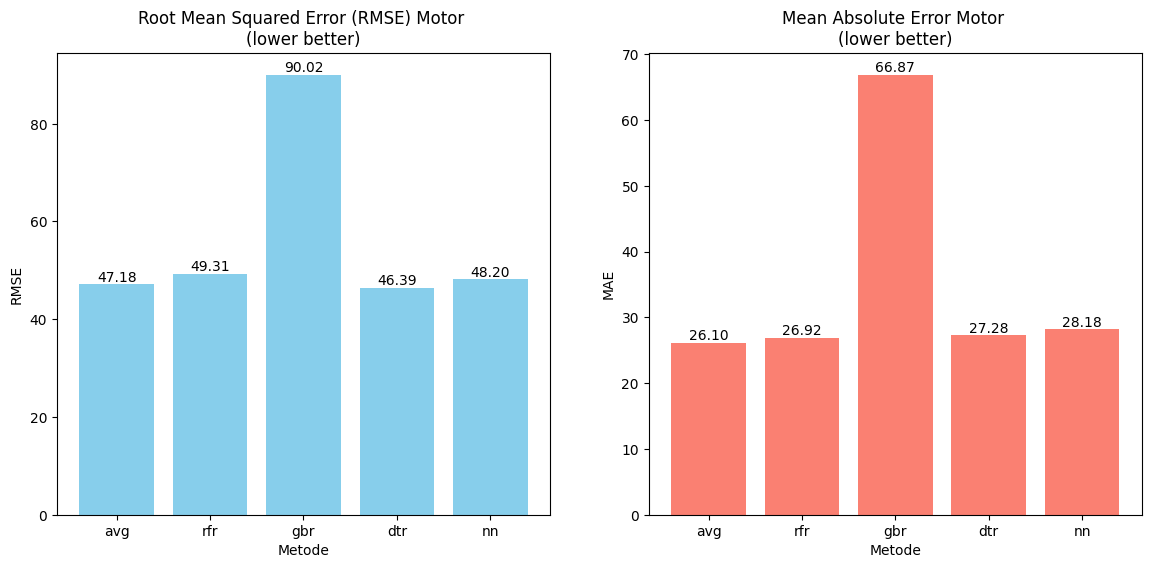

In [53]:
# Membuat figure dan dua subplot (untuk MSE dan R²)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot rMSE
bars_rmse = ax[0].bar(rmses.keys(), rmses.values(), color='skyblue')
ax[0].set_title('Root Mean Squared Error (RMSE) Motor \n(lower better)')
ax[0].set_xlabel('Metode')
ax[0].set_ylabel('RMSE')
# Menampilkan nilai pada batang RMSE
for bar in bars_rmse:
    yval = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

# Plot MAE
bars_mae = ax[1].bar(maes.keys(), maes.values(), color='salmon')
ax[1].set_title('Mean Absolute Error Motor \n(lower better)')
ax[1].set_xlabel('Metode')
ax[1].set_ylabel('MAE')

# Menampilkan nilai pada batang RMSE
for bar in bars_mae:
    yval = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

In [54]:
print(mses)
print(maes)
print(rmses)
print(mapes)
print(r2s)

{'avg': 2225.8865606964887, 'rfr': 2431.883179685837, 'gbr': 8103.126467883381, 'dtr': 2151.61706995551, 'nn': 2323.1711838783776}
{'avg': 26.0985105903317, 'rfr': 26.917400047322328, 'gbr': 66.8669170244559, 'dtr': 27.27852257037269, 'nn': 28.18088737483939}
{'avg': 47.17930224893633, 'rfr': 49.31412758719186, 'gbr': 90.01736759027882, 'dtr': 46.38552651372527, 'nn': 48.19928613453085}
{'avg': 17.46448650018327, 'dtr': 17.490962630435273, 'nn': 17.490962630435273}
{'avg': 0.9030057901148082, 'rfr': 0.8940293761093969, 'gbr': 0.6469018847455529, 'dtr': 0.9062421233135417, 'nn': 0.8987665600812016}


In [55]:
# Gabungkan tabel berdasarkan kolom "Actual"
result = data_avg.merge(data_rfr[['Predicted_rfr','Residual_rfr']], left_index=True, right_index=True) \
                 .merge(data_gbr[['Predicted_gbr','Residual_gbr']], left_index=True, right_index=True) \
                 .merge(data_dtr[['Predicted_dtr','Residual_dtr']], left_index=True, right_index=True) \
                 .merge(data_nn[['Predicted_nn','Residual_nn']], left_index=True, right_index=True)
result.head()

,Actual,Predicted_avg,Residual_avg,Predicted_rfr,Residual_rfr,Predicted_gbr,Residual_gbr,Predicted_dtr,Residual_dtr,Predicted_nn,Residual_nn
0,175,238.200000,-63.200000,246.820000,-71.820000,260.258251,-85.258251,250.744186,-75.744186,256.215668,-81.215668
1,37,50.875000,-13.875000,54.431440,-17.431440,107.811378,-70.811378,49.180328,-12.180328,51.804379,-14.804379
2,242,238.200000,3.800000,225.592095,16.407905,260.258251,-18.258251,226.865672,15.134328,247.020081,-5.020081
3,330,324.888889,5.111111,386.046325,-56.046325,260.258251,69.741749,334.445087,-4.445087,342.966095,-12.966095
4,173,187.805556,-14.805556,172.393500,0.606500,207.314624,-34.314624,184.059524,-11.059524,181.519455,-8.519455


In [56]:
import seaborn as sns

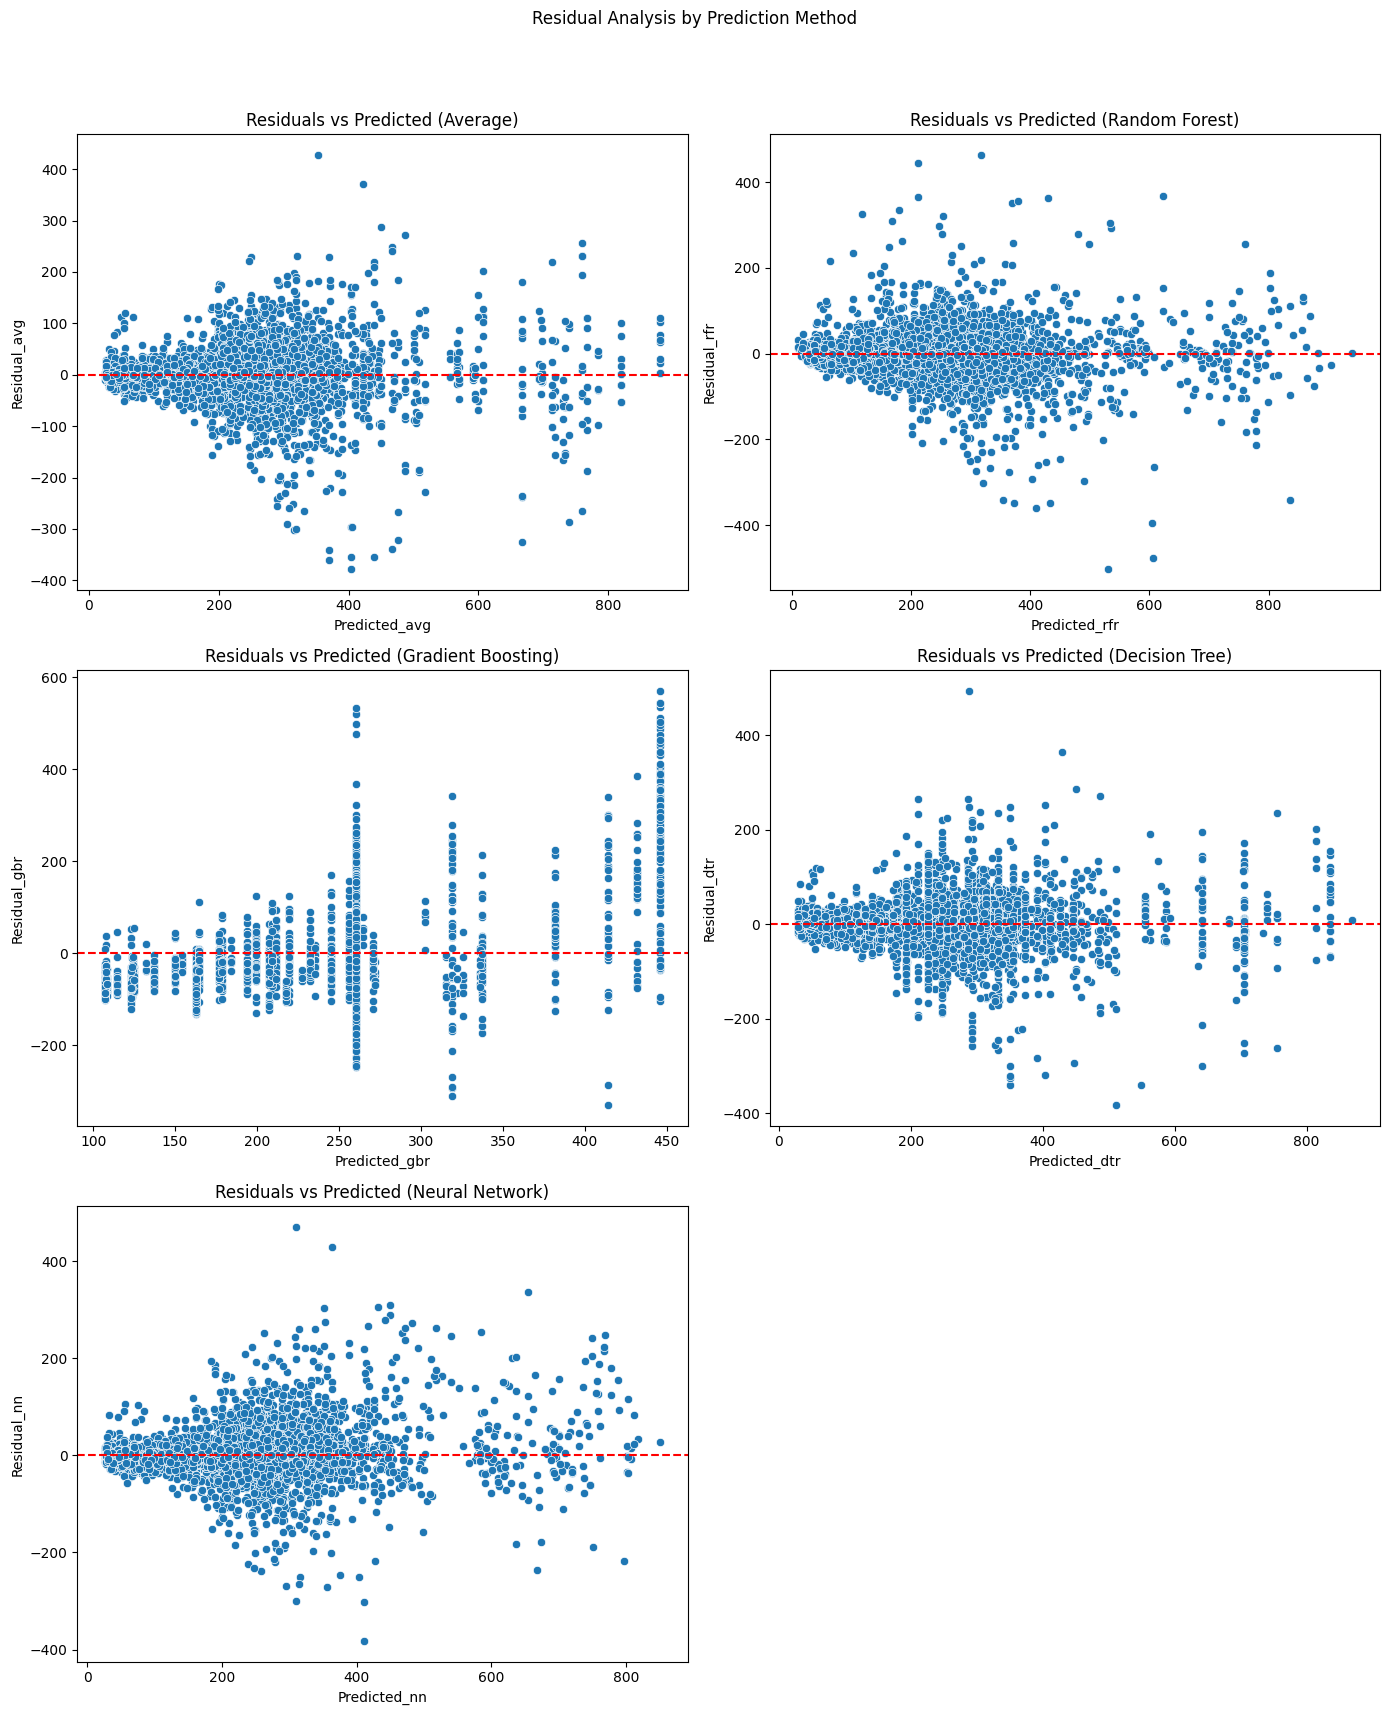

In [57]:
# Creating a DataFrame
df = result.copy()

# Set up the plot grid
fig, axes = plt.subplots(3, 2, figsize=(14, 18))
fig.suptitle('Residual Analysis by Prediction Method')

# Scatter plot for each model's residuals
sns.scatterplot(x=df['Predicted_avg'], y=df['Residual_avg'], ax=axes[0, 0])
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_title('Residuals vs Predicted (Average)')
axes[0, 0].set_xlabel('Predicted_avg')
axes[0, 0].set_ylabel('Residual_avg')

sns.scatterplot(x=df['Predicted_rfr'], y=df['Residual_rfr'], ax=axes[0, 1])
axes[0, 1].axhline(0, color='red', linestyle='--')
axes[0, 1].set_title('Residuals vs Predicted (Random Forest)')
axes[0, 1].set_xlabel('Predicted_rfr')
axes[0, 1].set_ylabel('Residual_rfr')

sns.scatterplot(x=df['Predicted_gbr'], y=df['Residual_gbr'], ax=axes[1, 0])
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].set_title('Residuals vs Predicted (Gradient Boosting)')
axes[1, 0].set_xlabel('Predicted_gbr')
axes[1, 0].set_ylabel('Residual_gbr')

sns.scatterplot(x=df['Predicted_dtr'], y=df['Residual_dtr'], ax=axes[1, 1])
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_title('Residuals vs Predicted (Decision Tree)')
axes[1, 1].set_xlabel('Predicted_dtr')
axes[1, 1].set_ylabel('Residual_dtr')

sns.scatterplot(x=df['Predicted_nn'], y=df['Residual_nn'], ax=axes[2, 0])
axes[2, 0].axhline(0, color='red', linestyle='--')
axes[2, 0].set_title('Residuals vs Predicted (Neural Network)')
axes[2, 0].set_xlabel('Predicted_nn')
axes[2, 0].set_ylabel('Residual_nn')

# Hide the last empty plot (since we have an odd number of plots)
axes[2, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()